# A Study of four financial time series. 

# Introduction : 

We are given four assets : A,B,C and D and will attempt to predict the closing prices of these assets using ARIMA and VAR models. We fit ARIMA and VAR models at first for just the data coming from each asset, we will then run the combined data through the models after employing a dimensionality reduction to obtain slightly better scores. In all cases, our models are tested using a rolling forecast test, which is a form of Cross Validation for time series data.
The final results can be summarized in the following tables.

In [1287]:
#When compiling run this at the end
Final_results_MASE

,ARIMA,VAR,Naive,VAR Combined,VAR + PCA
A,0.997083,0.996208,1.0,0.994839,0.998305
B,0.994859,0.991335,1.0,0.992670,0.992507
C,1.009271,1.008781,1.0,1.011703,1.015820
D,0.999472,1.006387,1.0,0.995893,0.996674


The MASE score measures how effective the model is against the naive model that predicts tomorrows price as today's price. In the case of assets A,B and D we find that our models perform slightly better than the naive prediction. 
In the case of asset C, the naive model is best. It is very possible that the models will outperform the naive model
if we were to forecast not just one days ahead but several days ahead. Rough results which we don't present here suggest this to be true.

In [1288]:
#When compiling run this at the end.
Final_results_MSE

,ARIMA,VAR,Naive,VAR Combined,VAR + PCA
A,0.153396,0.153176,0.153164,0.157962,0.159229
B,2.287908,2.279414,2.303413,2.139894,2.145245
C,0.005341,0.005357,0.005339,0.005382,0.005434
D,5.748741,5.740671,5.679302,5.703751,5.699656


We can also test our models using the mean squared error. We see above for instance that 
a VAR model for the combined data of all assets to predict asset B outperforms the naive model. However, the naive 
model beats the other methods in all other cases. 

In every instance of fitting the model, we have tuned the parameters involved using AIC/BIC scores as well as a 
rolling forecast test. 

# Exploratory Data Analysis  

In [897]:
#Importing necessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.plotting import scatter_matrix
import seaborn as sns
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import coint
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import ccf
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.decomposition import PCA

In [898]:
# We load the given data onto 4 pandas dataframes.

pathA = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/A.csv'
pathB = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/B.csv'
pathC = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/C.csv'
pathD = '/Users/Welliareetil/Documents/Cabestan-technical challenge/WelliaveetilDataset/D.csv'

In [899]:
A = pd.read_csv(pathA)
B = pd.read_csv(pathB)
C = pd.read_csv(pathC)
D = pd.read_csv(pathD)

In [900]:
#We rename the columns which will come in handy later when studying multiple assets simultaneously.

A.columns = ["date",'op_A', 'hi_A', 'lo_A', 'se_A', 'volume_A', 'oi_A']
B.columns = ["date",'op_B', 'hi_B', 'lo_B', 'se_B', 'volume_B', 'oi_B']
C.columns = ["date",'op_C', 'hi_C', 'lo_C', 'se_C', 'volume_C', 'oi_C']
D.columns = ["date",'op_D', 'hi_D', 'lo_D', 'se_D', 'volume_D', 'oi_D']

In [901]:
# We convert the date columns to timestamps.

A["date"] = pd.to_datetime(A["date"])
B["date"] = pd.to_datetime(B["date"])
C["date"] = pd.to_datetime(C["date"])
D["date"] = pd.to_datetime(D["date"])

In [902]:
#We make note of the start and end dates of the 4 time series. This will be useful when making plot comparisons. 

a_start = A['date'][0]
a_end = A['date'][len(A['date'])-1]
b_start = B['date'][0]
b_end = B['date'][len(B["date"])-1]
c_start = C['date'][0]
c_end = C['date'][6823]
d_start = D['date'][0]
d_end = D['date'][10025]

In [903]:
#We set the index of the 4 dataframes to be the date column. 

A.index = A["date"]
#del(A['date'])
B.index = B["date"]
#del(B['date'])
C.index = C['date']
#del(C['date'])
D.index = D['date']
#del(D['date'])


We will add a column for each time series which is the closing price of the asset for that day. 
We feel that for a particular asset, the features 'op', 'hi',
'lo', 'se', 'volume', 'oi' and 'cl', are known to us only at the close of business each day and hence it makes more
sense to check if this information (and all past values of the features) can then be employed to predict the closing price for the next day. 


In [904]:
#We add a column "closing price" to a given dataframe. We feel this is a more natural variable to predict.

def closing_price_column(df,op,s):
    l = pd.Series([df[op][j+1] for j in range(len(df)-1)] + [0])
    df = df.assign(cl = l.values)
    df = df.drop(df.index[-1])
    df.rename(columns = {'cl':s},inplace = True)
    df.drop(op, axis = 1,inplace = True)
    return(df)

In [905]:
A = closing_price_column(A,"op_A","cl_A")
B = closing_price_column(B,"op_B","cl_B")
C = closing_price_column(C,"op_C","cl_C")
D = closing_price_column(D,"op_D","cl_D")

In [906]:
#Rearrange the columns of the dataframe.

def rearrange(df,s):
    cols = list(df.columns)
    k = cols.index(s)
    t = cols[1]
    cols[k] = t
    cols[1] = s
    df = df[cols]
    return(df)

In [907]:
A = rearrange(A,'cl_A')
B = rearrange(B,'cl_B')
C = rearrange(C,'cl_C')
D = rearrange(D,'cl_D')

# Missing Values and dates

Checking for missing values and any unusual behaviour. We will go into a closer examination when building models 
below.

In [908]:
#A list of lists which gives the column count of missing values for each of the 4 assets

null_list = []
null_list.append(list(A.isnull().sum()))
null_list.append(list(B.isnull().sum()))
null_list.append(list(C.isnull().sum()))
null_list.append(list(D.isnull().sum()))
null_list

[[0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0],
 [0, 6, 6, 0, 8, 11, 6]]

We see that the series D has some missing values. 

We check if the data has certain dates missing. We do so by counting 
the number of days between the start and end dates of 
the different series and then multiplying this by (251/365) since 251 is a rough estimate of the number of
working days per year. We then subtract the length of the various series which we assume
counts the actual working days 
of the year and then normalize the error by dividing by the number of days between the start and end date. We see that 
this error rate is pretty much constant over all series.

In [909]:
"""A rough estimate of the number of days to expect is 251 out of 365. Hence for a given range x:y we 
calculate the number of calendar days in this range and then multiply by (251/365) to get a rough estimate of the
number of trading days. We compare this to the size of each data frame to make sure that data isn't
missing."""

def missing_days(A):
    a_start = A['date'][0]
    a_end = A['date'][len(A['date'])-1]
    deltaA = a_end - a_start
    e1 = deltaA.days*(251/365) - len(A)
    print(e1/deltaA.days)

In [910]:
missing_days(A)

-0.00126714871200338


In [911]:
missing_days(B)

-0.0020423488910734306


In [912]:
missing_days(C)

-0.001242337397924194


In [913]:
missing_days(D)

-0.00237557329068854


# Relationship between the closing price data of the 4 assets

In [914]:
#A.set_index("date")
#B.set_index("date")
#C.set_index('date')
#D.set_index('date')
#a_start = A['date'][0]
#a_end = A['date'][len(A['date'])-1]
#b_start = B['date'][0]
#b_end = B['date'][len(B["date"])-1]
#c_start = C['date'][0]
#c_end = C['date'][6823]
#d_start = D['date'][0]
#d_end = D['date'][10025]

In [1279]:
a = max(a_start,b_start,c_start,d_start)
b = min(a_end,b_end,c_end,d_end)

A comparison plot of the opening prices of A,B,C and D during the relevant time periods. 

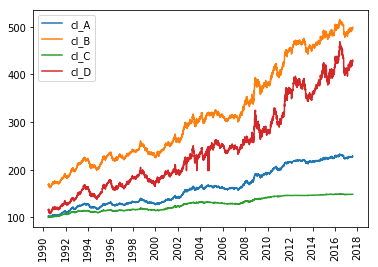

In [1286]:
fig,ax = plt.subplots()
ax.plot(A["date"][a:b],A[a:b]['cl_A'])
ax.plot(B["date"][a:b],B[a:b]['cl_B'])
ax.plot(C["date"],C['cl_C'])
ax.plot(D["date"][3135:9964],D[3135:9964]['cl_D'])
ax.xaxis.set_major_locator(mdates.YearLocator(2,month = 2,day = 2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.legend()
_=plt.xticks(rotation=90) 
plt.show()

We observe a very strong relationship between the series op_B and op_D. To be sure we calculate correlations between the returns (or in this case day to day changes) between the series. 

More precisely, for each asset, we create a data frame which captures the day to day change in price of each asset. This is necessary because estimates (Auto Correlations and Cross Correlations) are usually possible only for stationary series. 

In [917]:
A_ret = A.copy()
del(A_ret['date'])
A_ret = A_ret.pct_change()
A_ret = A_ret.dropna(axis = 0)

B_ret = B.copy()
del(B_ret['date'])
B_ret = B_ret.pct_change()
B_ret = B_ret.dropna(axis = 0)

C_ret = C.copy()
del(C_ret['date'])
C_ret = C_ret.pct_change()
C_ret = C_ret.dropna(axis = 0)

D_ret = D.copy()
del(D_ret['date'])
D_ret = D_ret.pct_change()
D_ret = D_ret.dropna(axis = 0)


We create a database that includes all the data from the 4 series A,B,C and D. We study the correlations between series. 

In [918]:
returns = A_ret.join(B_ret,how = 'inner')
returns = returns.join(C_ret,how = "inner")
returns = returns.join(D_ret,how = 'inner')

In [919]:
# We name the columns of return appropriately

l = []
for j in list(returns.columns):
    j = j + '_ret'    
    l.append(j)
returns.columns = l    

In [920]:
correlations_op = returns[['cl_A_ret','cl_B_ret','cl_C_ret','cl_D_ret']].corr()
print(correlations_op)

          cl_A_ret  cl_B_ret  cl_C_ret  cl_D_ret
cl_A_ret  1.000000  0.945473  0.823172  0.848949
cl_B_ret  0.945473  1.000000  0.754613  0.929732
cl_C_ret  0.823172  0.754613  1.000000  0.643761
cl_D_ret  0.848949  0.929732  0.643761  1.000000


We observe a very strong relation between A and B as well as D and B. The correlation matrix suggests that
all four assets are 
closely related to each other. 

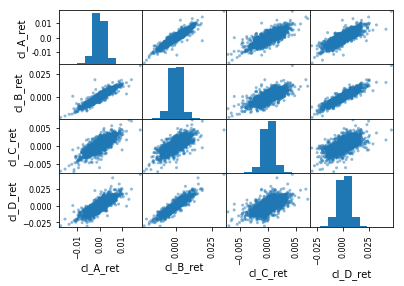

In [921]:
scatter_matrix(returns[['cl_A_ret','cl_B_ret','cl_C_ret','cl_D_ret']])
plt.show()

The scatter matrix suggest that there is a linear relationship between closing price data 
of the four assets.

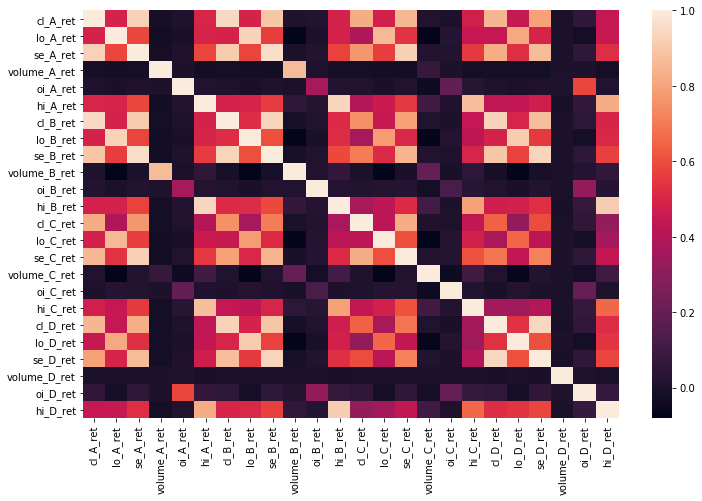

In [922]:
dims = (12,7.5)
fig,ax = plt.subplots(figsize = dims)
correlations = returns.corr()
sns.heatmap(ax = ax, data = correlations)
plt.show()
plt.savefig('correlation_matrix.png')

We make the following observations : 

1) The volume changes and changes in open interest from day to day show little correlation with the day to day changes of the other features (hi_ret,lo_ret,se_ret,op_ret) within the same series and
the other series.

2) For any two series, say A and B, we have strong correlations between cl_A_ret and cl_B_ret, hi_A_ret and hi_B_ret,
lo_A_ret and lo_B_ret, se_A_ret and se_B_ret. 

#  Functions we will use : 

We now list the functions we will call subsequently to process the data, clean it and also build models for it. 

# Preprocessing functions :

In [923]:
#Rename the columns so that they differ from those of A

def add_ret(B):
    t = []
    for j in list(B.columns):
        j = j + '_ret'    
        t.append(j)
    B.columns = t

In [924]:
#Function to correct missing values and outliers in a given entry of a column in a dataframe.

def insert_mean(S,i):
    S[i] = (S[i-1]+S[i+1])/2

In [925]:
"""Function checks for missing values and then fills them in."""

def rectify(df):
    cols = list(df.columns)
    for c in cols:
         S = df[c]
         nl = []
         A = S.isnull()
         for j in range(len(A)):
              if A[j] == True:
                nl.append(j)
         for j in nl:
             insert_mean(S,j)

In [926]:
"""check if series is random walk or not. Necessary since in 
many cases we are restricted to working with stationary series."""
def ad_fuller_test(S):
    results = adfuller(S)
    print("The p-value is " + str(results[1]))

In [927]:
"""function to plot the cross correlation for stationary series X and Y."""

def CCF(X,Y,s1):
    cross_corr = ccf(X,Y)
    plt.plot(cross_corr[0:250])
    plt.xlabel(s1)
    plt.show()

# Functions to build and test models :

We begin by building ARIMA models to get a measure of how noisy the various series are. 

In [928]:
"""The following function acts on a given time series and builds a ARIMA models at several parameter values.
It then outputs the AIC and BIC scores. We use these scores to choose a suitable model at a later stage.
In our case, we restrict our attention to just 5 ARIMA models and find that in some cases reasonable
accuracy can be achieved with this."""

def ARIMA_fitting_AIC_BIC_list(A):
    X = A.values
    size = int(len(X)*0.80)
    train = X[0:size]
    test = X[size:len(X)]
    AIC = []
    BIC = []
    for i in range(1,6):
        model = ARIMA(train,order = (i,1,0))
        model_fit = model.fit(disp=0)
        AIC.append(model_fit.aic)
        BIC.append(model_fit.bic)
    print('The AIC list is ' )
    print(AIC)
    print('The BIC list is ')
    print(BIC)

In [929]:
"""Given an ARIMA(p,d,q)-model, we test its predictive power by means of a rolling forecast. This function inputs 
a time series and the parameters of an ARIMA model and outputs a test series and predictions which the model makes."""

def ARIMA_rolling_forecast(A,p,d,q):
    X = A.values
    size = int(len(X)*0.80)
    train = X[0:size]
    test = X[size:len(X)]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(p,d,q))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
    return(test, predictions) 

In [930]:
"""We plot the predictions from the rolling forecast."""

def plot_predictions(test,predictions):
    plt.plot(predictions)
    plt.plot(test)
    plt.xlabel('Index of data point of test set')
    plt.ylabel('price')
    plt.legend()
    plt.show()

In [931]:
"""Mean squared error calculation"""

def MSE(test,predictions):
    error = mean_squared_error(test,predictions)
    return(error)
    #print(error)

In [932]:
"""The mean squared error might be misleading in this case. We hence define the mean absolute scaled error. 
The MASE tells us how much better or worse the given model is when compared to the very naive model which predicts
tomorrows value as todays value. An MASE which is greater than 1 implies that the model is worse than the naive model
while an MASE which is less than 1 implies that the model is better."""

def MASE(test,predictions):
    err = [test[j] - predictions[j] for j in range(len(test))]
    #Naive error calculation : 
    T = len(test)
    naive_error = 0
    for j in range(1,T):
        naive_error = naive_error + abs(test[j] - test[j-1])
    naive_error = (1/(T-1))*naive_error 
    scaled_errors = [x/naive_error for x in err[1:]]
    MASE = np.mean([abs(x) for x in scaled_errors])
    #print("The mean absolute scaled error is " + str(MASE))
    return(MASE)

We now build VAR models to make full use of the given data.

In [933]:
"""Function inputs a dataframe and a list of columns, and outputs a list of AIC and BIC scores for VAR(p) models 
(where p is the lag parameter). The columns indicated must be stationary series.""" 

def selecting_model(df,l):
    size = int(len(df)*0.7)
    data = df[l][0:size]
    model = VAR(data)
    return(model.select_order(30))

In [934]:
"""We test our VAR model using a rolling forecast. The input data is df - a dataframe, a list of columns
which are the set of variables of interest. The function outputs a test series and a prediction series.
An important point to note is that VAR models can only work with stationary series."""

def VAR_rolling_forecast(df,l,p,split):
    size = int(len(df)*split)
    predictions = list()
    test = []
    while size <= len(df)-1:
        data = df[0:size][l]
        model = VAR(data)
        model_fit = model.fit(p)
        output = model_fit.forecast(data.values,1)
        yhat = output[0][0]
        predictions.append(yhat)
        test.append(df[l[0]][size])
        size = size + 1
    return(test,predictions)

In [935]:
"""This is similar to the function above. We will use it when we build a model using multiple series as input data. 
For instance both A and B...In the function below, l is a list of column names, p is the lag parameter for the VAR model, h is the 
maximum amount of time in the future for which you wish to forecast, l1 is the list of columns which you 
wish to predict for. The output in this case are two dictionaries - one called test and the other called 
predictions."""

def VAR_rolling_forecast_general(df,l,p,l1,h):
    size = int(len(df)*0.80)
    predictions = {}
    test = {}
    for i in range(1,h+1):
        for j in l1:
            predictions[(j,i)] = []
            test[(j,i)] = []
    while size <= len(df)-h:
          data = df[0:size][l]
          model = VAR(data)
          model_fit = model.fit(p)
          output = model_fit.forecast(data.values,h)
          for j in l1:
            for i in range(1,h+1):
                k = l.index(j)
                yhat = output[i-1][k]
                predictions[(j,i)].append(yhat)
                test[(j,i)].append(df[j][size + i - 1])
          size = size + 1
    return(test,predictions)

In [936]:
"""Since the VAR model predicts the stationary returns series, we write a function
that recovers predictions for the original series."""

def recover_asset_predictions(S,size,test,predictions):
    test_adj = []
    for j in range(size+1,len(S)):
        test_adj.append(S[j])
    predictions_adj = []
    j = size
    t = 0
    while t <= len(predictions)-1 and j <= len(S)-1:
        predictions_adj.append(S[j]*(predictions[t]+1))
        t = t + 1
        j = j + 1
    return(test_adj,predictions_adj)

In [937]:
def naive_model(X):
    size = int(len(X)*0.80)
    test = X[size:len(X)]
    pred = []
    for j in range(size,len(X)):
        pred.append(X[j-1])
    return(test,pred)    

In [938]:
Final_results_MASE = [[0 for i in range(4)] for j in range(4)]
Final_results_MSE = [[0 for i in range(4)] for j in range(4)]

# We predict the opening prices of asset A.

In [939]:
A_ret.describe()

,cl_A,lo_A,se_A,volume_A,oi_A,hi_A
count,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000
mean,0.000112,0.000112,0.000112,inf,0.007094,0.000112
std,0.002599,0.002385,0.002519,NaN,0.391756,0.002468
min,-0.017423,-0.017679,-0.019006,-1.000000,-0.971345,-0.016938
25%,-0.001341,-0.001093,-0.001258,-0.231088,-0.009297,-0.001113
50%,0.000141,0.000146,0.000128,0.002941,0.001130,0.000063
75%,0.001582,0.001363,0.001529,0.309608,0.013352,0.001366
max,0.018204,0.015206,0.019735,inf,33.385878,0.019126


Observe that the summary statistics for the columns volume_A_ret and oi_A_ret present certain missing information. 
We correct this by making changes to the original dataframe.

In [940]:
mean_volume_A = A['volume_A'].mean()
A['volume_A']= A.volume_A.mask(A.volume_A == 0,mean_volume_A)
mean_oi_A = A['oi_A'].mean()
A['oi_A']= A.oi_A.mask(A.oi_A == 0,mean_oi_A)

In [941]:
"""Since we have changed the dataframe A, we redefine A_ret"""
A_ret = A.copy()
del(A_ret['date'])
A_ret = A_ret.pct_change()
A_ret = A_ret.dropna(axis = 0)

In [942]:
add_ret(A_ret)

In [943]:
A_ret.describe()

,cl_A_ret,lo_A_ret,se_A_ret,volume_A_ret,oi_A_ret,hi_A_ret
count,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000
mean,0.000112,0.000112,0.000112,9.495339,0.007094,0.000112
std,0.002599,0.002385,0.002519,803.208829,0.391756,0.002468
min,-0.017423,-0.017679,-0.019006,-0.999949,-0.971345,-0.016938
25%,-0.001341,-0.001093,-0.001258,-0.231088,-0.009297,-0.001113
50%,0.000141,0.000146,0.000128,0.002941,0.001130,0.000063
75%,0.001582,0.001363,0.001529,0.309608,0.013352,0.001366
max,0.018204,0.015206,0.019735,69202.000000,33.385878,0.019126


We observe that the standard deviation of the feature volume_B is 
larger than the other features. 

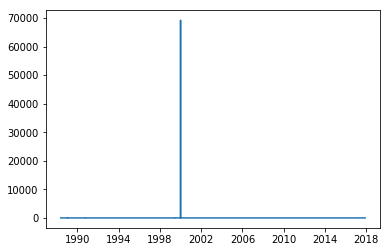

In [944]:
plt.plot(A_ret['volume_A_ret'])
plt.show()

We observe certain anomalies in the volume data and try to identify the precise points at which these anomalies occurred. 

In [945]:
outliersA = []
for j in range(len(A_ret)):
    if A_ret['volume_A_ret'][j] > 100:
        outliersA.append(j)
print(outliersA) 

[2923]


We alter the volume data at the index 2923 as it is an extreme outlier and
replace it with the values of the mean and the volume changes of the days before and after.

In [946]:
for j in outliersA:
    A_ret['volume_A_ret'][j] = A_ret['volume_A_ret'].mean()

In [947]:
A_ret.describe()

,cl_A_ret,lo_A_ret,se_A_ret,volume_A_ret,oi_A_ret,hi_A_ret
count,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000,7423.000000
mean,0.000112,0.000112,0.000112,0.173972,0.007094,0.000112
std,0.002599,0.002385,0.002519,1.384731,0.391756,0.002468
min,-0.017423,-0.017679,-0.019006,-0.999949,-0.971345,-0.016938
25%,-0.001341,-0.001093,-0.001258,-0.231088,-0.009297,-0.001113
50%,0.000141,0.000146,0.000128,0.002941,0.001130,0.000063
75%,0.001582,0.001363,0.001529,0.309608,0.013352,0.001366
max,0.018204,0.015206,0.019735,59.771923,33.385878,0.019126


We plot the autocorrelation function for the returns series - A_ret

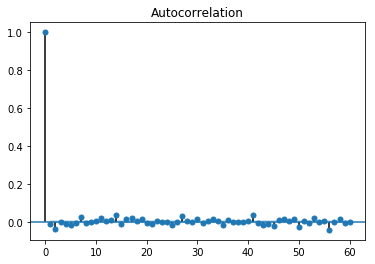

In [948]:
plot_acf(A_ret['cl_A_ret'],lags = 60,alpha = 0.5)

It looks like the series is a white noise process because we do not see any non trivial auto correlations beyond lag 0. 

We make test quickly if this observation is accurate using the Dicky-Fuller test on the series A_ret. 

In [949]:
ad_fuller_test(A['cl_A'])

The p-value is 0.950321143027


The test implies that A is a random walk. 

We fit ARIMA(p,d,q) models to predict the opening price of the asset A given its previous opening prices. 

We begin by finding the most suitable p,d and q using the AIC and BIC scores. 

In [950]:
ARIMA_fitting_AIC_BIC_list(A['cl_A'])

The AIC list is 
[6367.204734102899, 6352.779344174587, 6354.529740009555, 6355.675267806924, 6355.755810134089]
The BIC list is 
[6387.2721170688701, 6379.5358547958822, 6387.9753782861735, 6395.8100337388669, 6402.5797037213551]


The AIC and BIC scores tell us that a ARIMA(2,1,0) is a reasonable choice to make. We compute the MSE of the ARIMA(2,1,0) model as follows and find that on average the model has an error of 0.2024 using a Rolling forecast. 

Rolling forecast error calculation :

In [951]:
testA,predictions_A210 = ARIMA_rolling_forecast(A['cl_A'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


We see in the graph below that the predictions follow the test data almost perfectly. 

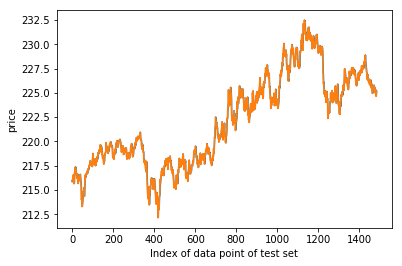

In [1273]:
plot_predictions(testA,predictions_A210)

In [953]:
MSE(testA,predictions_A210)

0.15339644446267098

In [954]:
a = MSE(testA,predictions_A210)
Final_results_MSE[0][0] = a

We calculate the mean absolute scaled error so as to be able to compare the models for the different series. 

In [956]:
MASE(testA,predictions_A210)

0.99708340743680879

In [957]:
a1 = MASE(testA,predictions_A210)

In [958]:
Final_results_MASE[0][0] = a1

We also test an ARIMA(5,1,0) model.

In [960]:
testA,predictions_A510 = ARIMA_rolling_forecast(A['cl_A'],5,1,0)  

In [961]:
MSE(testA,predictions_A510)

0.15322001187149034

In [962]:
MASE(testA,predictions_A510)

0.99693765619143582

# VAR models for closing price of asset A

We begin by selecting a suitable model for prediction. We do so in two ways. Firstly, 
by selecting according to the BIC score. 

In [963]:
selecting_model(A_ret,['cl_A_ret','hi_A_ret', 'lo_A_ret', 'se_A_ret', 'volume_A_ret', 'oi_A_ret'])

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -50.72       -50.71    9.410e-23       -50.71
1        -52.42       -52.37    1.716e-23       -52.40
2        -52.84       -52.74    1.128e-23       -52.80
3        -53.07       -52.92    8.979e-24       -53.02
4        -53.20       -53.01    7.828e-24       -53.14
5        -53.28       -53.04    7.257e-24       -53.20
6        -53.35       -53.07    6.783e-24       -53.25
7        -53.39      -53.07*    6.479e-24       -53.28
8        -53.43       -53.06    6.248e-24       -53.30
9        -53.46       -53.04    6.067e-24       -53.31
10       -53.48       -53.02    5.918e-24      -53.32*
11       -53.49       -52.98    5.869e-24       -53.31
12       -53.50       -52.95    5.819e-24       -53.31
13       -53.52       -52.92    5.727e-24       -53.31
14       -53.52       -52.87    5.716e-24       -53.29
15       -

{'aic': 18, 'bic': 7, 'fpe': 18, 'hqic': 10}

We now write a function that tests the model using a rolling forecast for the given data. 

** Make sure the date column has already been removed.

** Make sure the first element of the list l is the column 'cl_A_ret'

In [964]:
l = ['cl_A_ret','hi_A_ret', 'lo_A_ret', 'se_A_ret', 'volume_A_ret', 'oi_A_ret']
test, predictions = VAR_rolling_forecast(A_ret,l,7,split = 0.8)

In [965]:
size = int(len(A_ret)*0.8)
test,predictions = recover_asset_predictions(A['cl_A'],size,testB,predictions)

In [966]:
MSE(test,predictions)

0.15416406067127819

In [967]:
MASE(test,predictions)

0.99934240716961165

We observe that we don't beat the previous  use another approach when tuning the hyper-parameter p. We split into three segments [0:a], [a+1:b] and [b+1:]. For a given p, 
we fit a VAR(p) on the data in the segment [0:a] and then test this on [a+1:b]. We then choose the best 
such p and test on [b+1:]. We choose 'a' so that the segment [0:a] represents roughly 64% of the data, and we choose 
'b' so that [b+1,:] contains approximates 20% of the data. 

In [968]:
MASE_list = []
MSE_list = []
for p in range(1,4):
    size1 = int(len(A_ret)*.8)
    test, predictions = VAR_rolling_forecast(A_ret[0:size1],l,p,0.8) 
    size = int(len(A_ret[0:size1])*0.80)
    test,predictions = recover_asset_predictions(A[0:size1+1]['cl_A'],size,test,predictions) 
    MSE_list.append(MSE(test,predictions))
    MASE_list.append(MASE(test,predictions))

In [969]:
MSE_list

[0.3605325267243199, 0.35923642497468405, 0.36041877053542021]

In [970]:
MASE_list

[0.99626454109461049, 0.9960144308495289, 0.99648105974401247]

In [971]:
test, predictions = VAR_rolling_forecast(A_ret,l,2,0.8) 
size = int(len(A_ret)*0.80)
test,predictions = recover_asset_predictions(A['cl_A'],size,test,predictions) 
print("The MSE is " + str(MSE(test,predictions)))
print("The MASE is " + str(MASE(test,predictions)))

The MSE is 0.15317573829
The MASE is 0.996208228973


In [972]:
Final_results_MASE[0][1] = MASE(test,predictions)
Final_results_MSE[0][1] = MSE(test,predictions)

In [974]:
tst,prd = naive_model(A['cl_A'])
Final_results_MSE[0][2] = MSE(tst,prd)
Final_results_MASE[0][2] = MASE(tst,prd)

# We predict the closing price of asset B

We will study the returns dataframe associated to the asset B. Before doing so,
we make minor adjustments to the dataframe B to rectify issues with the column
volume_B_ret as seen below. 

In [975]:
B_ret.describe()

,cl_B,lo_B,se_B,volume_B,oi_B,hi_B
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000188,0.000187,0.000187,inf,0.020019,0.000186
std,0.004550,0.003997,0.004231,NaN,1.625826,0.004039
min,-0.030137,-0.025499,-0.024001,-1.000000,-0.992675,-0.022499
25%,-0.002288,-0.001829,-0.002102,-0.225134,-0.010818,-0.001830
50%,0.000126,0.000276,0.000150,0.004957,0.001439,0.000118
75%,0.002668,0.002230,0.002513,0.303968,0.014950,0.002216
max,0.044639,0.042678,0.036305,inf,153.604520,0.035004


In [976]:
mean_volume_B = B['volume_B'].mean()
B['volume_B']= B.volume_B.mask(B.volume_B == 0,mean_volume_B)
mean_oi_B = B['oi_B'].mean()
B['oi_B']= B.oi_B.mask(B.oi_B == 0,mean_oi_B)

In [977]:
"""Since we have changed the dataframe D, we redefine D_ret"""
B_ret = B.copy()
del(B_ret['date'])
B_ret = B_ret.pct_change()
B_ret = B_ret.dropna(axis = 0)

In [978]:
B_ret.describe()

,cl_B,lo_B,se_B,volume_B,oi_B,hi_B
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000188,0.000187,0.000187,0.243783,0.020019,0.000186
std,0.004550,0.003997,0.004231,7.118005,1.625826,0.004039
min,-0.030137,-0.025499,-0.024001,-0.998411,-0.992675,-0.022499
25%,-0.002288,-0.001829,-0.002102,-0.225134,-0.010818,-0.001830
50%,0.000126,0.000276,0.000150,0.004957,0.001439,0.000118
75%,0.002668,0.002230,0.002513,0.303968,0.014950,0.002216
max,0.044639,0.042678,0.036305,645.428571,153.604520,0.035004


We observe that the standard deviation of the feature volume_B is 
larger than the other features. 

In [979]:
add_ret(B_ret)

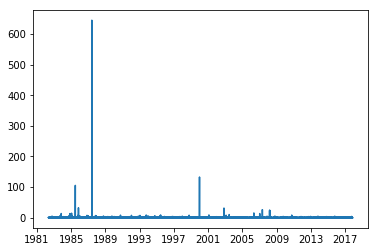

In [980]:
plt.plot(B_ret['volume_B_ret'])
plt.show()

We observe certain anomalies in the volume data and try to identify the precise points at which these anomalies occurred. 

In [981]:
outliersB = []
for j in range(len(B_ret)):
    if B_ret['volume_B_ret'][j] > 100:
        outliersB.append(j)
print(outliersB)  

[797, 1285, 4454]


There are two days which had significant volume changes - 05/06/1985 - 645%, 28/06/2001 - 132%. We consider these extreme outliers and hence alter the information here by replace the values with the mean of the volume changes of the days before and after. 

In [982]:
for j in outliersB:
    B_ret['volume_B_ret'][j] = B_ret['volume_B_ret'].mean()

In [983]:
B_ret.describe()

,cl_B_ret,lo_B_ret,se_B_ret,volume_B_ret,oi_B_ret,hi_B_ret
count,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000,8957.000000
mean,0.000188,0.000187,0.000187,0.145215,0.020019,0.000186
std,0.004550,0.003997,0.004231,0.992099,1.625826,0.004039
min,-0.030137,-0.025499,-0.024001,-0.998411,-0.992675,-0.022499
25%,-0.002288,-0.001829,-0.002102,-0.225134,-0.010818,-0.001830
50%,0.000126,0.000276,0.000150,0.004957,0.001439,0.000118
75%,0.002668,0.002230,0.002513,0.303225,0.014950,0.002216
max,0.044639,0.042678,0.036305,32.110540,153.604520,0.035004


We plot the ACF for the returns series of B which is stationary. 

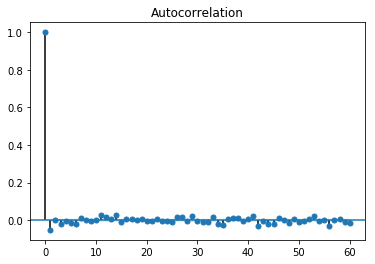

In [984]:
plot_acf(B_ret['cl_B_ret'],lags = 60,alpha = 0.5)

In [985]:
ad_fuller_test(B['cl_B'])

The p-value is 0.962604036252


It is extremely likely that B is a random walk.

In [986]:
ARIMA_fitting_AIC_BIC_list(B['cl_B'])

The AIC list is 
[21541.39964972225, 21531.6183016243, 21533.617490389217, 21534.75229594119, 21535.181237305533]
The BIC list is 
[21562.030539743038, 21559.126154985352, 21568.00230709053, 21576.014075982763, 21583.319980687367]


Selection in this case is slightly more difficult. We choose the ARIMA(1,1,0) model. We will also test the ARIMA(4,1,0) model and the ARIMA(2,1,0) model. 

In [987]:
testB,predictions_B110 = ARIMA_rolling_forecast(B['cl_B'],1,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [1272]:
#plot_predictions(testB,predictions_B110)

In [989]:
errorB110 = mean_squared_error(testB,predictions_B110)
print(errorB110)

2.28790773263


In [990]:
Final_results_MSE[1][0] = errorB110

In [991]:
MASE(testB,predictions_B110)

0.99485922209537103

In [992]:
h1 = MASE(testB,predictions_B110)
Final_results_MASE[1][0] = h1

We see that the mean absolute scaled error in this case indicates that the model performs WORSE than 
a model which predicts tomorrows opening price as todays price. To be sure we employ an ARIMA(2,1,0) model as well. 

In [994]:
testB,predictions_B210 = ARIMA_rolling_forecast(B['cl_B'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


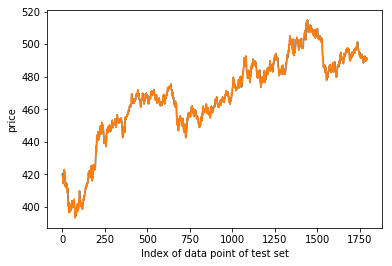

In [995]:
plot_predictions(testB,predictions_B210)

 We calculate the MSE below.

In [996]:
errorB210 = mean_squared_error(testB,predictions_B210)
print(errorB210)

2.29235353532


In [997]:
MASE(testB,predictions_B210)

0.99573934266998332

# VAR models for asset B

To reduce the scaled error, we look to fit VAR models for the asset B. 

In [998]:
#CCF(B_ret['op_B_ret'],B_ret['hi_B_ret'],'op_B_ret vs hi_B_ret')
#CCF(B_ret['op_B_ret'],B_ret['lo_B_ret'],'op_B_ret vs lo_B_ret')

We begin by selecting a suitable model for prediction. We do so by selecting according to the BIC score. 

In [999]:
selecting_model(B_ret,['cl_B_ret','hi_B_ret', 'lo_B_ret', 'se_B_ret', 'volume_B_ret', 'oi_B_ret'])

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -44.52       -44.51    4.636e-20       -44.52
1        -46.53       -46.49    6.192e-21       -46.52
2        -46.96       -46.88    4.018e-21       -46.93
3        -47.19       -47.06    3.213e-21       -47.14
4        -47.31       -47.14    2.855e-21       -47.25
5        -47.39       -47.19    2.613e-21       -47.32
6        -47.46       -47.22    2.436e-21       -47.38
7        -47.51       -47.23    2.324e-21       -47.41
8        -47.55      -47.23*    2.232e-21       -47.44
9        -47.58       -47.22    2.176e-21       -47.45
10       -47.60       -47.20    2.134e-21       -47.46
11       -47.61       -47.18    2.104e-21       -47.46
12       -47.62       -47.15    2.078e-21       -47.46
13       -47.64       -47.13    2.036e-21      -47.47*
14       -47.65       -47.10    2.013e-21       -47.46
15       -

{'aic': 28, 'bic': 8, 'fpe': 28, 'hqic': 13}

As before we test the model using a rolling forecast for the given data. 

In [1000]:
l = ['cl_B_ret','hi_B_ret', 'lo_B_ret', 'se_B_ret', 'volume_B_ret', 'oi_B_ret']
testB, predictions_BVAR8 = VAR_rolling_forecast(B_ret,l,8,split = 0.8)

In [1001]:
size = int(len(B_ret)*0.8)
testB_adj,predictions_BVAR8_adj = recover_asset_predictions(B['cl_B'],size,testB,predictions_BVAR8)

In [1002]:
MSE(testB_adj,predictions_BVAR8_adj)

2.2828285286768062

In [1003]:
MASE(testB_adj,predictions_BVAR8_adj)

0.99546429130119429

We find that the scores obtained are not better than the previous ARIMA(1,1,0) model. It follows that we must change 
our approach when tuning the hyper-parameter p. We split into three segments [0:a], [a+1:b] and [b+1:]. For a given p, 
we fit a VAR(p) on the data in the segment [0:a] and then test this on [a+1:b]. We then choose the best 
such p and test on [b+1:]. We choose 'a' so that the segment [0:a] represents roughly 64% of the data, and we choose 
'b' so that [b+1,:] contains approximates 20% of the data. 

In [1004]:
MASE_list = []
MSE_list = []
for p in range(1,4):
    size1 = int(len(B_ret)*.8)
    test, predictions = VAR_rolling_forecast(B_ret[0:size1],l,p,0.8) 
    size = int(len(B_ret[0:size1])*0.80)
    test,predictions = recover_asset_predictions(B[0:size1+1]['cl_B'],size,test,predictions) 
    MSE_list.append(MSE(test,predictions))
    MASE_list.append(MASE(test,predictions))

In [1005]:
MSE_list

[2.4541430808865923, 2.4491812805290376, 2.4691141199200737]

In [1006]:
MASE_list

[1.0008676113816228, 1.000108681247015, 1.0041123885044327]

We see that the VAR(2) model outperforms the other models. We test this model on the remaining data. 

In [1007]:
test, predictions = VAR_rolling_forecast(B_ret,l,3,0.8) 
size = int(len(B_ret)*0.80)
test,predictions = recover_asset_predictions(B['cl_B'],size,test,predictions) 
print("The MSE is" + str(MSE(test,predictions)))
print("The MASE is" + str(MASE(test,predictions)))

The MSE is2.27941438888
The MASE is0.991335340699


In [1008]:
Final_results_MSE[1][1] = MSE(test,predictions)
Final_results_MASE[1][1] = MASE(test,predictions)

We see that we marginally beat the previous ARIMA scores.  

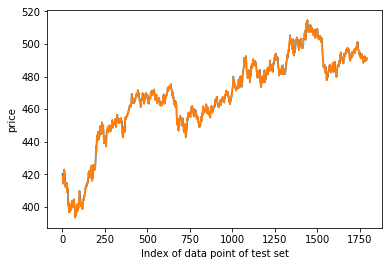

In [1009]:
plot_predictions(test,predictions)

In [1010]:
tst,prd = naive_model(B['cl_B'])
Final_results_MSE[1][2] = MSE(tst,prd)
Final_results_MASE[1][2] = MASE(tst,prd)

# We predict the closing price of asset C

We will study the returns dataframe associated to the asset C. Before doing so,
we make minor adjustments to the dataframe C_ret.

In [1011]:
C_ret.describe()

,cl_C,lo_C,se_C,volume_C,oi_C,hi_C
count,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000,6822.000000
mean,0.000059,0.000058,0.000058,0.274278,0.002201,0.000058
std,0.001083,0.000985,0.001021,1.521008,0.051717,0.001025
min,-0.007143,-0.009263,-0.009231,-0.984305,-0.315962,-0.007571
25%,-0.000461,-0.000385,-0.000430,-0.290468,-0.009697,-0.000383
50%,0.000000,0.000000,0.000000,-0.000942,0.001623,0.000000
75%,0.000587,0.000502,0.000546,0.406833,0.014493,0.000478
max,0.007069,0.007599,0.008664,56.071429,0.489942,0.009767


In [1012]:
add_ret(C_ret)

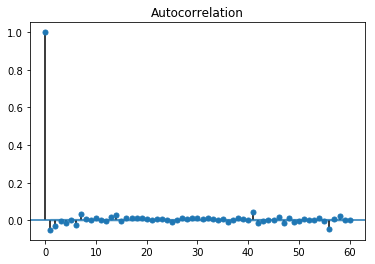

In [1013]:
plot_acf(C_ret['cl_C_ret'],lags = 60,alpha = 0.5)

In [1014]:
ad_fuller_test(C['cl_C'])

The p-value is 0.494953457692


We see that the p-value indicates that there is a high chance that C is a random walk. 

In [1017]:
ARIMA_fitting_AIC_BIC_list(C['cl_C'])

The AIC list is 
[-5574.7984884682755, -5581.111399167434, -5579.608265122153, -5579.608938610623, -5577.671238003646]
The BIC list is 
[-5554.9845250667167, -5554.6927812986887, -5546.5849927862218, -5539.9810118075056, -5531.4386567333422]


In [1018]:
testC,predictions_C210 = ARIMA_rolling_forecast(C['cl_C'],2,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


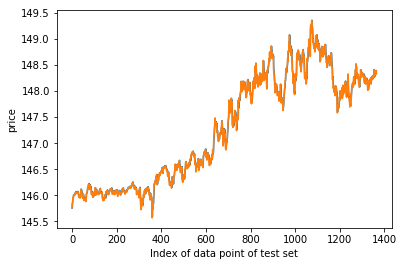

In [1267]:
plot_predictions(testC,predictions_C210)

In [1020]:
errorC210 = mean_squared_error(testC,predictions_C210)
print(errorC210)

0.00534066763861


In [1021]:
Final_results_MSE[2][0] = errorC210

In [1022]:
MASE(testC,predictions_C210)

1.0092707897689566

In [1023]:
Final_results_MASE[2][0] = MASE(testC,predictions_C210)

# VAR models to predict the closing price of C

To reduce the scaled error, we look to fit VAR models for the asset C. 
We begin by selecting a suitable model for prediction. We do so by selecting according to the BIC score. 

In [1024]:
selecting_model(C_ret,['cl_C_ret','hi_C_ret', 'lo_C_ret', 'se_C_ret', 'volume_C_ret', 'oi_C_ret'])

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -60.97       -60.97    3.306e-27       -60.97
1        -62.81       -62.75    5.273e-28       -62.79
2        -63.20       -63.10    3.555e-28       -63.17
3        -63.42       -63.27    2.859e-28       -63.37
4        -63.57       -63.36    2.473e-28       -63.50
5        -63.65       -63.39    2.281e-28       -63.56
6        -63.72      -63.42*    2.122e-28       -63.61
7        -63.77       -63.42    2.021e-28       -63.65
8        -63.79       -63.39    1.972e-28       -63.65
9        -63.82       -63.37    1.917e-28       -63.66
10       -63.84       -63.34    1.877e-28      -63.67*
11       -63.85       -63.31    1.855e-28       -63.66
12       -63.87       -63.27    1.826e-28       -63.66
13       -63.87       -63.23    1.820e-28       -63.65
14       -63.88       -63.18    1.813e-28       -63.63
15       -

{'aic': 20, 'bic': 6, 'fpe': 20, 'hqic': 10}

As before we test the model using a rolling forecast for the given data. 

In [1025]:
l = list(C_ret.columns)
test, predictions = VAR_rolling_forecast(C_ret,l,8,split = 0.8)

In [1026]:
size = int(len(C_ret)*0.8)
test,predictions = recover_asset_predictions(C['cl_C'],size,test,predictions)

In [1027]:
MSE(test,predictions)

0.0053664032561036275

In [1028]:
MASE(test,predictions)

1.0156999528257247

The scores dont beat the ARIMA model and hence as before we tune our parameters a little differently. 

In [1029]:
MASE_list = []
MSE_list = []
for p in range(1,4):
    size1 = int(len(C_ret)*.8)
    test, predictions = VAR_rolling_forecast(C_ret[0:size1],l,p,0.8) 
    size = int(len(C_ret[0:size1])*0.80)
    test,predictions = recover_asset_predictions(C[0:size1+1]['cl_C'],size,test,predictions) 
    MSE_list.append(MSE(test,predictions))
    MASE_list.append(MASE(test,predictions))

In [1030]:
MSE_list

[0.025736212245157174, 0.02563450133973098, 0.025611945048193214]

In [1031]:
MASE_list

[0.99785959828429316, 0.99758151260205707, 0.99734227027959155]

We see that the VAR(3) model outperforms the other models. We tested this model on the remaining data but found it doesn't not outperform the ARIMA model. Hence, we test the Var(2) model to see if we can beat the ARIMA(2,1,0) model
from before. 

In [1032]:
test, predictions = VAR_rolling_forecast(C_ret,l,2,0.8) 
size = int(len(C_ret)*0.80)
test,predictions = recover_asset_predictions(C['cl_C'],size,test,predictions) 
print("The MSE is " + str(MSE(test,predictions)))
print("The MASE is " + str(MASE(test,predictions)))

The MSE is 0.00535723653469
The MASE is 1.00878089932


In [1034]:
Final_results_MSE[2][1] = MSE(test,predictions)
Final_results_MASE[2][1] = MASE(test,predictions)

In [1035]:
tst,prd = naive_model(C['cl_C'])
Final_results_MSE[2][2] = MSE(tst,prd)
Final_results_MASE[2][2] = MASE(tst,prd)

We observe a slight improvement in model performance. 

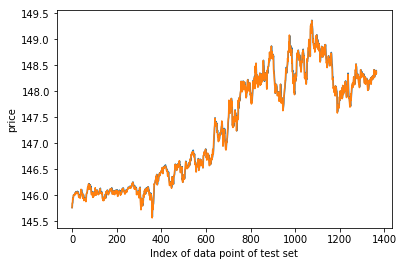

In [1038]:
plot_predictions(test,predictions)

# We predict the closing price of asset D

In [1039]:
D.isnull().sum()

date         0
cl_D         6
lo_D         6
se_D         0
volume_D     8
oi_D        11
hi_D         6
dtype: int64

In [1040]:
D = D.fillna(D.mean())

In [1041]:
mean_volume_D = D['volume_D'].mean()
D['volume_D']= D.volume_D.mask(D.volume_D == 0,mean_volume_D)
mean_oi_D = D['oi_D'].mean()
D['oi_D']= D.oi_D.mask(D.oi_D == 0,mean_oi_D)

In [1042]:
"""Since we have changed the dataframe D, we redefine D_ret"""
D_ret = D.copy()
del(D_ret['date'])
D_ret = D_ret.pct_change()
D_ret = D_ret.dropna(axis = 0)

In [1043]:
add_ret(D_ret)

In [1044]:
D_ret.describe()

,cl_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,hi_D_ret
count,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000
mean,0.000184,0.000177,0.000169,23.366408,0.006579,0.000177
std,0.008950,0.008093,0.007047,2252.308801,0.262218,0.008088
min,-0.184909,-0.184259,-0.032905,-0.999998,-0.957955,-0.184553
25%,-0.003918,-0.003032,-0.003646,-0.222465,-0.012464,-0.003045
50%,0.000277,0.000277,0.000273,0.003471,0.000886,0.000000
75%,0.004278,0.003446,0.004084,0.297815,0.016089,0.003434
max,0.229256,0.234833,0.040624,225446.000000,21.371707,0.231097


We observe that the feature 'volume_D_ret' has some issues with it, in that the standard deviation is extremely 
large compared to the mean. We fix this by adjusting the values at the outliers. 

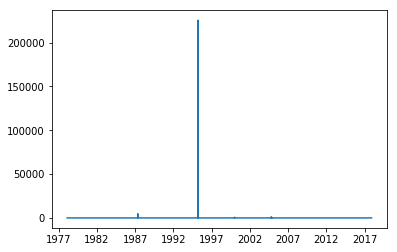

In [1045]:
plt.plot(D_ret['volume_D_ret'])
plt.show()

In [1046]:
outliers = []
for j in range(len(D_ret)):
    if D_ret['volume_D_ret'][j] > 100:
        outliers.append(j)
print(outliers)        

[2328, 4315, 5516, 6716, 6739]


In [1047]:
for j in outliers:
    D_ret['volume_D_ret'][j] = D_ret['volume_D_ret'].mean()

In [1048]:
D_ret.describe()

,cl_D_ret,lo_D_ret,se_D_ret,volume_D_ret,oi_D_ret,hi_D_ret
count,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000,10024.000000
mean,0.000184,0.000177,0.000169,0.156140,0.006579,0.000177
std,0.008950,0.008093,0.007047,1.163974,0.262218,0.008088
min,-0.184909,-0.184259,-0.032905,-0.999998,-0.957955,-0.184553
25%,-0.003918,-0.003032,-0.003646,-0.222465,-0.012464,-0.003045
50%,0.000277,0.000277,0.000273,0.003471,0.000886,0.000000
75%,0.004278,0.003446,0.004084,0.297636,0.016089,0.003434
max,0.229256,0.234833,0.040624,52.438596,21.371707,0.231097


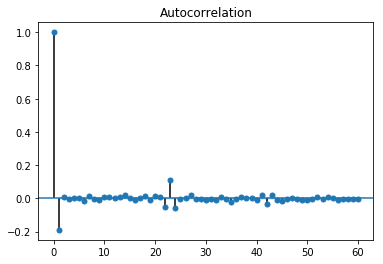

In [1049]:
plot_acf(D_ret['cl_D_ret'],lags = 60,alpha = 0.5)

We observe a lag 1,22,23 and 24 auto correlation.

In [1050]:
ARIMA_fitting_AIC_BIC_list(D['cl_D'])

The AIC list is 
[29946.645917331523, 29881.34861843575, 29878.690206779807, 29879.986834983632, 29880.76469433135]
The BIC list is 
[29967.614624345944, 29909.306894454978, 29913.638051803842, 29921.924249012474, 29929.691677364997]


In [1051]:
testD, predictions_D110 = ARIMA_rolling_forecast(D['cl_D'],1,1,0)

/Users/Welliareetil/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


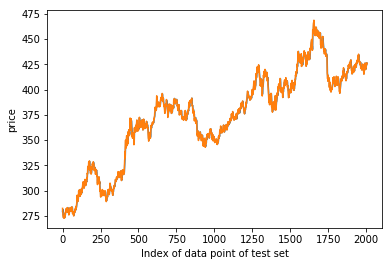

In [1266]:
plot_predictions(testD,predictions_D110)

In [1053]:
MSE(testD,predictions_D110)

5.7487408213961366

In [1054]:
Final_results_MASE[3][0] = MASE(testD,predictions_D110)
Final_results_MSE[3][0] = MSE(testD,predictions_D110)

In [1055]:
MASE(testD,predictions_D110)

0.99947200671807124

In [1056]:
#The MASE indicates that the ARIMA model is a very poor predictor in this case. 

# VAR models for asset D

In [1065]:
#u = []
#for j in list(D_ret.columns):
#    u.append(j[0:-4]) #

In [1067]:
#D_ret.columns = u

In [1069]:
selecting_model(D_ret,['cl_D_ret','hi_D_ret', 'lo_D_ret', 'se_D_ret', 'volume_D_ret', 'oi_D_ret'])

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -41.97       -41.96    5.941e-19       -41.97
1        -44.36       -44.32    5.416e-20       -44.35
2        -44.81       -44.74    3.444e-20       -44.79
3        -45.02       -44.91    2.805e-20       -44.98
4        -45.15       -45.01    2.456e-20       -45.10
5        -45.21       -45.03    2.317e-20       -45.15
6        -45.26      -45.05*    2.199e-20       -45.19
7        -45.30       -45.04    2.128e-20       -45.21
8        -45.33       -45.04    2.057e-20       -45.23
9        -45.35       -45.02    2.020e-20       -45.24
10       -45.36       -45.01    1.988e-20      -45.24*
11       -45.37       -44.98    1.970e-20       -45.24
12       -45.38       -44.95    1.953e-20       -45.23
13       -45.38       -44.92    1.948e-20       -45.22
14       -45.39       -44.89    1.940e-20       -45.22
15       -

{'aic': 26, 'bic': 6, 'fpe': 26, 'hqic': 10}

In [1070]:
lD = ['cl_D_ret','hi_D_ret', 'lo_D_ret', 'se_D_ret', 'volume_D_ret', 'oi_D_ret']
test, predictions = VAR_rolling_forecast(D_ret,lD,25,split = 0.8)

In [1071]:
size = int(len(D_ret)*0.8)
test,predictions = recover_asset_predictions(D['cl_D'],size,test,predictions)

In [1072]:
MSE(test,predictions)

5.7644992665449131

In [1073]:
MASE(test,predictions)

1.0075378542850073

We use another method other than simply looking at the BIC/AIC score to tune
parameters. We are restricted computationaly and cannot tune in this way for large p. 

In [1074]:
MASE_list = []
MSE_list = []
for p in range(1,4):
    size1 = int(len(D_ret)*.8)
    test, predictions = VAR_rolling_forecast(D_ret[0:size1],lD,p,0.8) 
    size = int(len(D_ret[0:size1])*0.80)
    test,predictions = recover_asset_predictions(D[0:size1+1]['cl_D'],size,test,predictions) 
    MSE_list.append(MSE(test,predictions))
    MASE_list.append(MASE(test,predictions))

In [1075]:
MSE_list

[8.384365491663047, 8.1799299237406196, 8.1657964264485958]

In [1076]:
MASE_list

[1.021741555900139, 1.0176172694821368, 1.0232394360229018]

We test the VAR(2) model on the remaining data. 

In [1077]:
test, predictions = VAR_rolling_forecast(D_ret,lD,1,0.8) 
size = int(len(D_ret)*0.80)
test,predictions = recover_asset_predictions(D['cl_D'],size,test,predictions) 
print("The MSE is " + str(MSE(test,predictions)))
print("The MASE is " + str(MASE(test,predictions)))

The MSE is 5.74067088399
The MASE is 1.0063872243


In [1078]:
Final_results_MASE[3][1] = MASE(test,predictions)

In [1079]:
Final_results_MSE[3][1] = MSE(test,predictions)

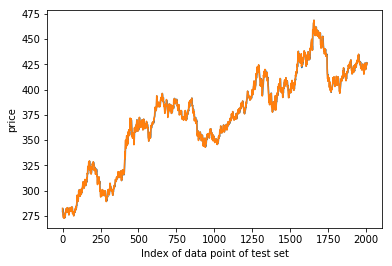

In [1080]:
plot_predictions(test,predictions)

In [1081]:
tst,prd = naive_model(D['cl_D'])
Final_results_MSE[3][2] = MSE(tst,prd)
Final_results_MASE[3][2] = MASE(tst,prd)

# Joint VAR models for A,B,C and D

In [1082]:
returns = A_ret.join(B_ret,how = 'inner')
returns = returns.join(C_ret,how = "inner")
returns = returns.join(D_ret,how = 'inner')

In [1083]:
combined_data = A.merge(B,on = 'date')
combined_data = combined_data.merge(C,on = 'date')
combined_data = combined_data.merge(D,on = 'date')

In [1084]:
l = ['cl_A_ret','volume_A_ret','oi_A_ret',
     'cl_B_ret','volume_B_ret','oi_B_ret',
     'cl_C_ret','volume_C_ret','oi_C_ret','cl_D_ret','volume_D_ret','oi_D_ret']
selecting_model(returns,l)

                 VAR Order Selection                  
            aic          bic          fpe         hqic
------------------------------------------------------
0        -71.10       -71.08    1.326e-31       -71.09
1        -71.86      -71.65*    6.158e-32      -71.79*
2        -71.90       -71.49    5.940e-32       -71.76
3       -71.90*       -71.30   5.936e-32*       -71.69
4        -71.87       -71.07    6.111e-32       -71.59
5        -71.85       -70.85    6.264e-32       -71.50
6        -71.81       -70.62    6.490e-32       -71.39
7        -71.79       -70.40    6.668e-32       -71.30
8        -71.75       -70.17    6.891e-32       -71.20
9        -71.72       -69.94    7.112e-32       -71.09
10       -71.69       -69.72    7.305e-32       -71.00
11       -71.66       -69.49    7.524e-32       -70.90
12       -71.66       -69.29    7.533e-32       -70.83
13       -71.63       -69.06    7.825e-32       -70.72
14       -71.59       -68.83    8.086e-32       -70.62
15       -

{'aic': 3, 'bic': 1, 'fpe': 3, 'hqic': 1}

In [1085]:
l1 = ['cl_A_ret','cl_B_ret','cl_C_ret','cl_D_ret']
test,predictions = VAR_rolling_forecast_general(returns,l,1,l1,1)

In [1086]:
l2 = ['cl_A','cl_B','cl_C','cl_D']
MASE_d = {}
MSE_d = {} 
size = int(len(returns)*0.80)
for j in range(4):
    test1,predictions1 = recover_asset_predictions(combined_data[l2[j]],size,test[(l1[j],1)],predictions[(l1[j],1)]) 
    MASE_d[l2[j]] = MASE(test1,predictions1)
    MSE_d[l2[j]] = MSE(test1,predictions1)

In [1087]:
MASE_d

{'cl_A': 0.99483933154731952,
 'cl_B': 0.99267040741737556,
 'cl_C': 1.0117033058817724,
 'cl_D': 0.99589276762044365}

In [1088]:
MSE_d

{'cl_A': 0.15796224218396185,
 'cl_B': 2.1398937964468634,
 'cl_C': 0.0053818950125045914,
 'cl_D': 5.7037512269962942}

In [1089]:
for j in range(4):
    Final_results_MASE[j][3] = MASE_d[l2[j]]
    Final_results_MSE[j][3] = MSE_d[l2[j]]

# Dimension reduction + VAR for the combined series

In [1185]:
pca_returns = PCA(n_components = 6)

In [1102]:
l = returns.columns
l1 = ['cl_A_ret','cl_B_ret','cl_C_ret','cl_D_ret']
#l = [x for x in l if x not in ['cl_A_ret','cl_B_ret','cl_C_ret','cl_D_ret']]

In [1193]:
l3 = [j for j in l if j not in l1]
returns_ret = pd.DataFrame(pca_returns.fit_transform(returns[l3]))

In [1194]:
pca_returns.explained_variance_ratio_

array([ 0.52984171,  0.26950419,  0.10980426,  0.08720913,  0.00224024,
        0.0007216 ])

We see that the first three features of the reduced_ret dataframe contributes to nearly 86% of the total variance 
amongst all features.

In [1165]:
"""This is an adaptation of the VAR models we built previously. We use it to tune the PCA parameter n. Our method as
before is to split the time interval into three segments [0:a], [a+1,b] and then [b+1,:]. We then fit our model on 
[0:a] and use a rolling forecast to test several candidate PCA parameters."""

def pca_VAR_rolling_forecast_general(df,l,l1,n):
    predictions = {}
    test = {}
    for i in range(1,n+1):
        for j in l1:
            predictions[(j,i)] = []
            test[(j,i)] = [] 
    for i in range(1,n+1):
        size = int(len(df)*0.80)
        pca_mod = PCA(n_components = n)
        l3 = [j for j in l if j not in l1]
        df_red = pd.DataFrame(pca_mod.fit_transform(df[l3]))
        df_red.index = df.index
        df_red = pd.merge(df_red,df[l1],left_index = True,right_index = True)
        t = list(df_red.columns)
        while size <= len(df)-1:
              data = df_red[0:size]
              model = VAR(data)
              model_fit = model.fit(maxlags = 5,ic = 'aic')
              output = model_fit.forecast(data.values,1)
              for j in l1:
                  k = t.index(j)
                  yhat = output[0][k]
                  predictions[(j,i)].append(yhat)
                  test[(j,i)].append(df[j][size])
              size = size + 1
    return(test,predictions)

In [1253]:
"""We call this function to test the final PCA+VAR model."""

def pca_var(df,l,l1,n):
    test = {}
    predictions = {}
    for j in l1:
        predictions[j] = []
        test[j] = [] 
    size = int(len(df)*0.8)    
    pca_mod = PCA(n_components = n)
    l3 = [j for j in l if j not in l1]
    df_red = pd.DataFrame(pca_mod.fit_transform(df[l3]))
    df_red.index = df.index
    df_red = pd.merge(df_red,df[l1],left_index = True,right_index = True)
    t = list(df_red.columns)
    while size <= len(df)-1:
          data = df_red[0:size]
          model = VAR(data)
          model_fit = model.fit(maxlags = 5,ic = 'aic')
          output = model_fit.forecast(data.values,1)
          for j in l1:
              k = t.index(j)
              yhat = output[0][k]
              predictions[j].append(yhat)
              test[j].append(df[j][size])
          size = size + 1 
    return(test,predictions)

In [1167]:
size = int(len(returns)*0.8)
n = 8
test,predictions = pca_VAR_rolling_forecast_general(returns[0:size],l,l1,n)

In [1248]:
pca_mod = PCA(n_components = 6)
df = returns
df_red = pd.DataFrame(pca_mod.fit_transform(df[l3]))
df_red.index = df.index
df_red = pd.merge(df_red,df[l1],left_index = True,right_index = True)


In [1179]:
l2 = ['cl_A','cl_B','cl_C','cl_D']
MASE_d = {}
MSE_d = {} 
s = int(len(returns)*0.80)
size = int(len(returns[0:s])*0.80)
for j in range(4):
    for i in range(1,n+1):
        test1,predictions1 = recover_asset_predictions(combined_data[0:s+1][l2[j]],size,test[(l1[j],i)],predictions[(l1[j],i)]) 
        MASE_d[(l2[j],i)] = MASE(test1,predictions1)
        MSE_d[(l2[j],i)] = MSE(test1,predictions1)

In [1291]:
MASE_d

{('cl_A', 1): 0.99837757167304209,
 ('cl_A', 2): 0.99837757167304064,
 ('cl_A', 3): 0.99837757167302432,
 ('cl_A', 4): 0.99837757167302665,
 ('cl_A', 5): 0.99837757167303065,
 ('cl_A', 6): 0.99837757167301555,
 ('cl_A', 7): 0.99837757167302876,
 ('cl_A', 8): 0.99837757167303876,
 ('cl_B', 1): 1.0015624272534998,
 ('cl_B', 2): 1.001562427253504,
 ('cl_B', 3): 1.0015624272534949,
 ('cl_B', 4): 1.0015624272534951,
 ('cl_B', 5): 1.0015624272535009,
 ('cl_B', 6): 1.0015624272534911,
 ('cl_B', 7): 1.0015624272534944,
 ('cl_B', 8): 1.001562427253508,
 ('cl_C', 1): 1.0053911518594387,
 ('cl_C', 2): 1.0053911518594347,
 ('cl_C', 3): 1.0053911518594465,
 ('cl_C', 4): 1.0053911518594447,
 ('cl_C', 5): 1.0053911518594367,
 ('cl_C', 6): 1.0053911518594443,
 ('cl_C', 7): 1.0053911518594381,
 ('cl_C', 8): 1.0053911518594296,
 ('cl_D', 1): 1.0017754910183982,
 ('cl_D', 2): 1.001775491018398,
 ('cl_D', 3): 1.0017754910183903,
 ('cl_D', 4): 1.001775491018392,
 ('cl_D', 5): 1.0017754910183949,
 ('cl_D', 

In [1290]:
MSE_d

{('cl_A', 1): 0.37078704920885625,
 ('cl_A', 2): 0.37078704920885858,
 ('cl_A', 3): 0.37078704920884675,
 ('cl_A', 4): 0.37078704920884359,
 ('cl_A', 5): 0.37078704920884864,
 ('cl_A', 6): 0.37078704920884059,
 ('cl_A', 7): 0.37078704920884759,
 ('cl_A', 8): 0.37078704920885674,
 ('cl_B', 1): 3.7214126249715842,
 ('cl_B', 2): 3.7214126249715851,
 ('cl_B', 3): 3.7214126249715203,
 ('cl_B', 4): 3.7214126249714941,
 ('cl_B', 5): 3.7214126249715127,
 ('cl_B', 6): 3.7214126249714856,
 ('cl_B', 7): 3.7214126249715025,
 ('cl_B', 8): 3.7214126249716122,
 ('cl_C', 1): 0.025853170858748841,
 ('cl_C', 2): 0.025853170858748841,
 ('cl_C', 3): 0.02585317085874925,
 ('cl_C', 4): 0.025853170858749649,
 ('cl_C', 5): 0.025853170858749063,
 ('cl_C', 6): 0.025853170858749282,
 ('cl_C', 7): 0.025853170858749198,
 ('cl_C', 8): 0.025853170858748765,
 ('cl_D', 1): 6.2058833522426848,
 ('cl_D', 2): 6.2058833522426893,
 ('cl_D', 3): 6.2058833522425783,
 ('cl_D', 4): 6.2058833522425791,
 ('cl_D', 5): 6.205883352

The values above suggest that a PCA parameter n = 6 might be optimum. 

In [1261]:
tst,prd = pca_var(returns,l,l1,6)

In [1257]:
"""Calculate the MASE scores for PCA n = 6"""

l2 = ['cl_A','cl_B','cl_C','cl_D']
MASE_d_final = {}
MSE_d_final = {} 
size = int(len(returns)*0.80)
for j in range(4):
    test1,predictions1 = recover_asset_predictions(combined_data[l2[j]],size,tst[l1[j]],prd[l1[j]]) 
    MASE_d_final[l2[j]] = MASE(test1,predictions1)
    MSE_d_final[l2[j]] = MSE(test1,predictions1)

In [1259]:
for j in range(4):
    Final_results_MASE[j].append(MASE_d_final[l2[j]])
    Final_results_MSE[j].append(MSE_d_final[l2[j]])


In [1262]:
Final_results_MASE = pd.DataFrame(Final_results_MASE)
Final_results_MSE = pd.DataFrame(Final_results_MSE)

In [1263]:
l4 = ['ARIMA','VAR','Naive','VAR Combined','VAR + PCA']
Final_results_MASE.columns = l4
Final_results_MSE.columns = l4
Final_results_MASE.index = ['A','B','C','D']
Final_results_MSE.index = ['A','B','C','D']

In [1265]:
Final_results_MASE.head()

,ARIMA,VAR,Naive,VAR Combined,VAR + PCA
A,0.997083,0.996208,1.0,0.994839,0.998305
B,0.994859,0.991335,1.0,0.992670,0.992507
C,1.009271,1.008781,1.0,1.011703,1.015820
D,0.999472,1.006387,1.0,0.995893,0.996674
